### **0. Libraries & Functions**

In [1]:
import re, nltk, spacy, string
from os import path
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
from wordcloud import WordCloud
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import pyLDAvis
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px
from collections import Counter
from textblob import TextBlob

# Download NLTK resources (if not already downloaded)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lukas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lukas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lukas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
def preprocess_text(text, word_freq, min_freq=2):
    # Text cleaning: Remove irrelevant characters, symbols, and special characters
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove smileys or emoticons
    cleaned_text = re.sub(r'(:|;)(-)?(\)|D|P)', '', cleaned_text)

    # Lowercasing: Convert text to lowercase
    cleaned_text = cleaned_text.lower()

    # Remove numerical values
    cleaned_text = re.sub(r'\d+', '', cleaned_text)

    # Spell correction using TextBlob
    #cleaned_text = str(TextBlob(cleaned_text).correct())

    # Tokenization: Split text into words or tokens
    words = word_tokenize(cleaned_text)

    # Update stopwwords with not meaningful words
    stop_words = set(stopwords.words('english'))

    # Filter out words that are not frequent enough
    words = [word for word in words if word_freq[word] >= min_freq]

    # Stopword removal: Eliminate common and irrelevant words
    words = [word for word in words if word not in stop_words]

    # Lemmatization: Reduce words to their root or base form
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    return ' '.join(words)

### **1. Data Import & Preprocessing**

In [3]:
data_directory = '/Users/lukas/OneDrive/01_Projects/Conduct your own end-to-end analytics project/Code/Upload'

# features
wine_df = pd.read_csv(path.join(data_directory, 'wine_df.csv'), low_memory=False)

In [4]:
text_df = wine_df[['review_id', 'review','rating_label']]

print('We have',len(text_df), 'reviews in the data')

We have 80021 reviews in the data


In [5]:
# creating a frequency counter to exlcude non-frequent words as they don't add value
word_freq = Counter()

for text in text_df['review']: 
    words = word_tokenize(text.lower()) 
    word_freq.update(words)

In [6]:
# pre-process the data 
text_df["review_processed"] = text_df['review'].apply(lambda x: preprocess_text(x, word_freq, 2))

C:\Users\lukas\AppData\Local\Temp\ipykernel_21452\2970255142.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### **2. Exploratory Analysis**

In [7]:
text = " ".join(review for review in text_df.review_processed)

c:\Users\lukas\anaconda3\envs\py311\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



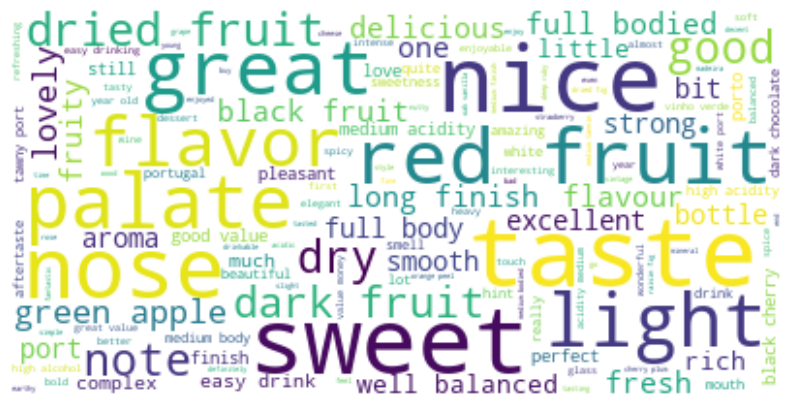

In [8]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

wordcl = WordCloud(background_color='white', max_font_size = 50, max_words = 5000).generate(text)
plt.figure(figsize=(10, 8))
plt.imshow(wordcl, interpolation='bilinear')
plt.axis('off')
plt.show()

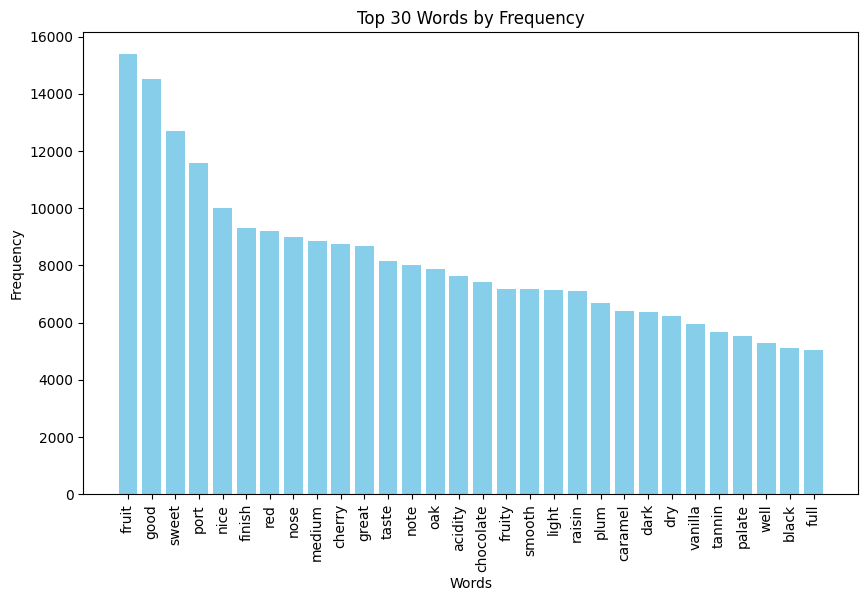

In [9]:
# Tokenizing and counting the words
from collections import Counter
import itertools

#plt.style.use('fivethirtyeight')

text_series = pd.Series(text_df["review_processed"])

# Split each string into words and flatten the list
all_words = list(itertools.chain(*text_series.apply(lambda x: x.split())))

# Count the frequencies of each word
word_freq = Counter(all_words)

# Create a DataFrame from the word frequencies
df_word_freq = pd.DataFrame(word_freq.items(), columns=['Word', 'Frequency'])

# Sort the DataFrame in descending order of frequency
df_sorted = df_word_freq.sort_values(by='Frequency', ascending=False).reset_index(drop=True)

top_words = df_sorted.head(30)

# Creating the bar plot
plt.figure(figsize=(10, 6))
plt.bar(top_words['Word'], top_words['Frequency'], color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 30 Words by Frequency')
plt.xticks(rotation=90)
plt.show()

C:\Users\lukas\AppData\Local\Temp\ipykernel_21452\1703245766.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



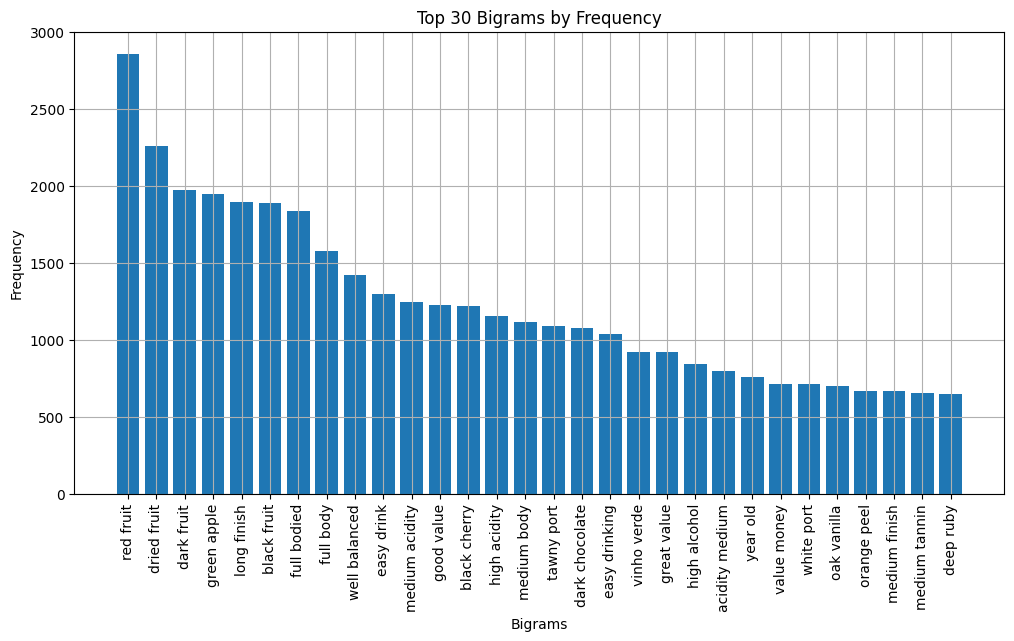

In [10]:
# Assuming the provided text is a pandas Series or a column in a DataFrame
# We will simulate it as a pandas Series for this example
import pandas as pd

data = text_df["review_processed"]
# Creating a pandas Series from the provided data
review_processed_series = pd.Series(data)

# Create bigrams from the lists of words
bigrams = list(itertools.chain(*[zip(review.split(), review.split()[1:]) for review in review_processed_series]))

# Count the frequencies of each bigram
bigram_freq = Counter(bigrams)

# Creating a DataFrame from the bigram frequencies
df_bigram_freq = pd.DataFrame(bigram_freq.items(), columns=['Bigram', 'Frequency'])

# Sort the DataFrame in descending order of frequency
df_sorted_bigrams = df_bigram_freq.sort_values(by='Frequency', ascending=False).reset_index(drop=True)

# Taking the top 10 bigrams for the bar plot for clarity
top_bigrams = df_sorted_bigrams.head(30)

# Convert bigram tuples to strings for plotting
top_bigrams['Bigram'] = top_bigrams['Bigram'].apply(lambda x: ' '.join(x))

# Creating the bar plot
plt.figure(figsize=(12, 6))
plt.bar(top_bigrams['Bigram'], top_bigrams['Frequency'])
plt.xlabel('Bigrams')
plt.ylabel('Frequency')
plt.title('Top 30 Bigrams by Frequency')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

C:\Users\lukas\AppData\Local\Temp\ipykernel_21452\44358052.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



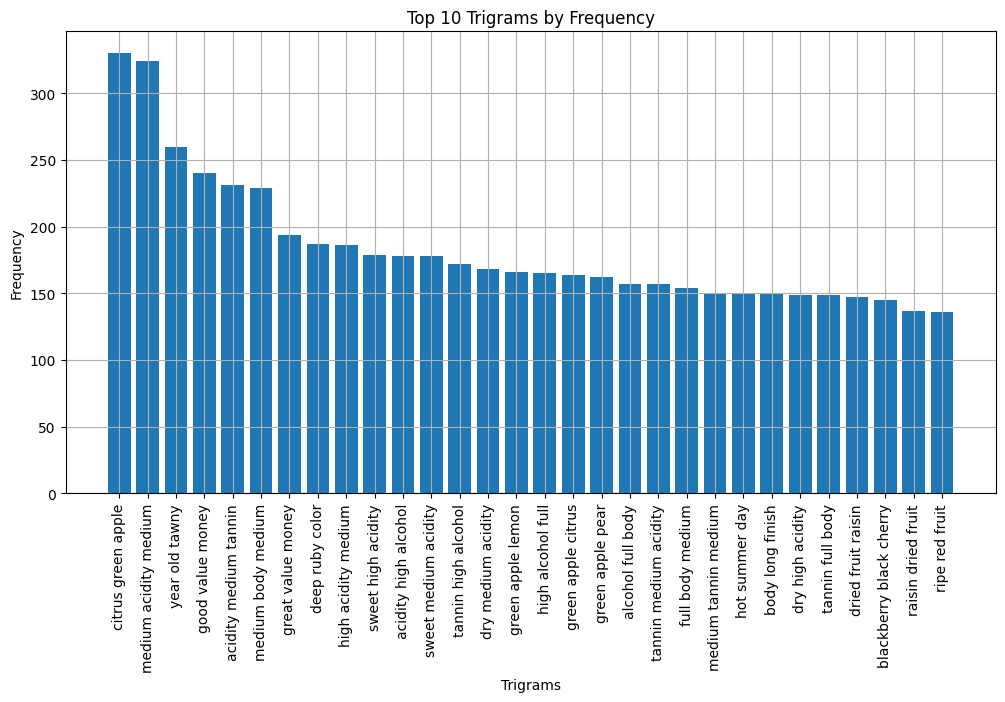

In [11]:
trigrams = list(itertools.chain(*[zip(review.split(), review.split()[1:], review.split()[2:]) for review in review_processed_series]))

# Count the frequencies of each trigram
trigram_freq = Counter(trigrams)

# Creating a DataFrame from the trigram frequencies
df_trigram_freq = pd.DataFrame(trigram_freq.items(), columns=['Trigram', 'Frequency'])

# Sort the DataFrame in descending order of frequency
df_sorted_trigrams = df_trigram_freq.sort_values(by='Frequency', ascending=False).reset_index(drop=True)

# Taking the top 10 trigrams for the bar plot for clarity
top_trigrams = df_sorted_trigrams.head(30)

# Convert trigram tuples to strings for plotting
top_trigrams['Trigram'] = top_trigrams['Trigram'].apply(lambda x: ' '.join(x))

# Creating the bar plot for trigrams
plt.figure(figsize=(12, 6))
plt.bar(top_trigrams['Trigram'], top_trigrams['Frequency'])
plt.xlabel('Trigrams')
plt.ylabel('Frequency')
plt.grid(True)
plt.title('Top 10 Trigrams by Frequency')
plt.xticks(rotation=90)
plt.show()


### **3. Modelling**

In [12]:
import gensim
from gensim.utils import simple_preprocess

# tokenize the comments
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data = text_df.review_processed.values.tolist()
data_words = list(sent_to_words(data))

print(data_words[:1][0][:30])

['okay', 'saying', 'euro', 'cad', 'cant', 'really', 'say', 'anything', 'negative', 'enjoying', 'first', 'night', 'portugal', 'sipping', 'light', 'refreshing', 'white', 'balcony', 'life', 'good']


In [13]:
# Build the bigram and trigram models to capture also frequent combinations like vinho verde 
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [14]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [15]:
# Form Bigrams to include examples like vino verde
data_words_bigrams = make_bigrams(data_words)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1][0][:1000])

['say', 'cad', 'really', 'say', 'negative', 'enjoy', 'first', 'night', 'portugal', 'sipping', 'light', 'refresh', 'white', 'balcony', 'life', 'good']


In [16]:
import gensim.corpora as corpora

# Create Dictionary to be more flexible 
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1)]


#### a. Base Model

In [17]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [18]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

transformed_corpus = lda_model.print_topics()

[(0,
  '0.139*"great" + 0.088*"good" + 0.053*"well" + 0.041*"value" + 0.038*"price" '
  '+ 0.033*"excellent" + 0.029*"pair" + 0.026*"amazing" + 0.023*"balanced" + '
  '0.018*"cheese"'),
 (1,
  '0.212*"port" + 0.051*"raisin" + 0.045*"good" + 0.022*"taste" + 0.021*"nice" '
  '+ 0.018*"sweet" + 0.016*"favorite" + 0.014*"plum" + 0.014*"ever" + '
  '0.014*"solid"'),
 (2,
  '0.090*"smooth" + 0.060*"fig" + 0.041*"dry" + 0.036*"rich" + 0.034*"sweet" + '
  '0.033*"nice" + 0.028*"port" + 0.023*"honey" + 0.021*"douro" + '
  '0.020*"complex"'),
 (3,
  '0.042*"toffee" + 0.040*"grape" + 0.023*"linger" + 0.022*"blend" + '
  '0.020*"make" + 0.018*"silky" + 0.018*"night" + 0.017*"warm" + 0.016*"last" '
  '+ 0.016*"different"'),
 (4,
  '0.063*"light" + 0.046*"fresh" + 0.035*"citrus" + 0.031*"apple" + '
  '0.031*"mineral" + 0.024*"white" + 0.023*"pear" + 0.023*"note" + '
  '0.021*"lemon" + 0.021*"fruit"'),
 (5,
  '0.048*"medium" + 0.038*"finish" + 0.037*"acidity" + 0.031*"full" + '
  '0.029*"body" + 0.02

In [19]:
# Parsing the output to create a DataFrame
data = {}
for topic_num, words in transformed_corpus:
    words_clean = [word.split('*')[1].replace('"', '').strip() for word in words.split('+')]
    data[f"Topic {topic_num}"] = words_clean

# Transposing the data to get the desired format
df = pd.DataFrame(data).transpose()
df.columns = [f"Word {i}" for i in range(1, 11)]  # Column names as Word 1, Word 2, ...

df

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10
Topic 0,great,good,well,value,price,excellent,pair,amazing,balanced,cheese
Topic 1,port,raisin,good,taste,nice,sweet,favorite,plum,ever,solid
Topic 2,smooth,fig,dry,rich,sweet,nice,port,honey,douro,complex
Topic 3,toffee,grape,linger,blend,make,silky,night,warm,last,different
Topic 4,light,fresh,citrus,apple,mineral,white,pear,note,lemon,fruit
Topic 5,medium,finish,acidity,full,body,long,dry,tawny,nose,fruit
Topic 6,year,drink,easy,old,bottle,good,well,still,vintage,much
Topic 7,delicious,wood,taste,heavy,first,elegant,get,note,time,try
Topic 8,fruit,cherry,chocolate,black,oak,red,dark,vanilla,blackberry,note
Topic 9,sweet,taste,fruity,bit,strong,little,light,dry,nice,good


In [20]:
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.5526954061777902


### **4. Hypertuning**

In [21]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [22]:
import numpy as np
import tqdm

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

100%|██████████| 540/540 [8:01:44<00:00, 53.53s/it]  


In [28]:
lda_tuning_results = pd.read_csv(path.join(data_directory, 'lda_tuning_results.csv'))

In [32]:
lda_tuning_results.sort_values(by='Coherence', ascending=False)

,Validation_Set,Topics,Alpha,Beta,Coherence
387,100% Corpus,5,asymmetric,0.61,0.667679
386,100% Corpus,5,asymmetric,0.31,0.666788
389,100% Corpus,5,asymmetric,symmetric,0.659449
385,100% Corpus,5,asymmetric,0.01,0.657824
507,100% Corpus,9,asymmetric,0.61,0.652397
...,...,...,...,...,...
69,75% Corpus,4,0.31,symmetric,0.526835
351,100% Corpus,4,symmetric,0.31,0.523289
68,75% Corpus,4,0.31,0.9099999999999999,0.521104
263,75% Corpus,10,symmetric,0.9099999999999999,0.514183


In [36]:
lda_tuning_results.groupby('Topics').agg(mean = ('Coherence', 'mean')).sort_values(by='mean', ascending=False)

,mean
Topics,
5,0.596412
7,0.581928
4,0.580426
6,0.578940
8,0.578136
9,0.575382
3,0.575380
10,0.572916
2,0.569529


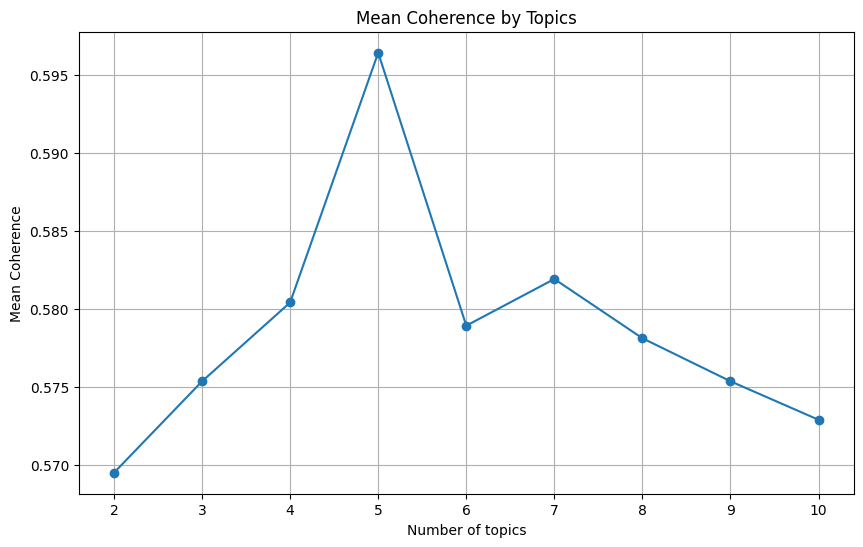

In [42]:
df = lda_tuning_results.groupby('Topics').agg(mean = ('Coherence', 'mean')).reset_index()

# Create the line plot
plt.figure(figsize=(10, 6))
plt.plot(df['Topics'], df['mean'], marker='o')  # 'o' adds circle markers

# Adding titles and labels
plt.title('Mean Coherence by Topics')
plt.xlabel('Number of topics')
plt.ylabel('Mean Coherence')
plt.grid(True)

# Show the plot
plt.show()

In [51]:
N = len(id2word)
best_beta = [0.61] * N

In [52]:
import pandas as pd

# Load the results
results_df = pd.read_csv('lda_tuning_results.csv')

# Find the best model
best_model_params = results_df.loc[results_df['Coherence'].idxmax()]

# Extract the best parameters
best_k = best_model_params['Topics']
best_alpha = best_model_params['Alpha']
best_beta = best_model_params['Beta']

# beta is a symmetric
N = len(id2word)
best_beta = [0.61] * N

In [53]:
best_lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                            num_topics=best_k, 
                                            random_state=100,
                                            chunksize=100,
                                            passes=10,
                                            alpha=best_alpha,
                                            eta=best_beta)

In [54]:
# Save the model
best_lda_model.save('best_lda_model.model')

In [55]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(best_lda_model.print_topics())
doc_lda = best_lda_model[corpus]

transformed_corpus = best_lda_model.print_topics()

[(0,
  '0.067*"good" + 0.056*"great" + 0.039*"fruity" + 0.031*"nice" + '
  '0.027*"light" + 0.024*"well" + 0.021*"drink" + 0.020*"smooth" + '
  '0.018*"price" + 0.017*"value"'),
 (1,
  '0.075*"port" + 0.056*"sweet" + 0.028*"taste" + 0.027*"tawny" + '
  '0.024*"raisin" + 0.019*"caramel" + 0.016*"fig" + 0.016*"nice" + '
  '0.015*"rich" + 0.014*"dry"'),
 (2,
  '0.044*"medium" + 0.040*"acidity" + 0.026*"finish" + 0.026*"dry" + '
  '0.024*"high" + 0.023*"fruit" + 0.020*"body" + 0.019*"alcohol" + '
  '0.018*"nose" + 0.018*"aroma"'),
 (3,
  '0.058*"fruit" + 0.035*"cherry" + 0.031*"chocolate" + 0.026*"tannin" + '
  '0.026*"oak" + 0.025*"red" + 0.025*"black" + 0.022*"dark" + 0.021*"full" + '
  '0.021*"vanilla"'),
 (4,
  '0.034*"year" + 0.017*"old" + 0.016*"bottle" + 0.013*"well" + 0.012*"taste" '
  '+ 0.012*"time" + 0.011*"get" + 0.011*"try" + 0.010*"wine" + 0.010*"still"')]


In [56]:
# Parsing the output to create a DataFrame
data = {}
for topic_num, words in transformed_corpus:
    words_clean = [word.split('*')[1].replace('"', '').strip() for word in words.split('+')]
    data[f"Topic {topic_num}"] = words_clean

# Transposing the data to get the desired format
df = pd.DataFrame(data).transpose()
df.columns = [f"Word {i}" for i in range(1, 11)]  # Column names as Word 1, Word 2, ...

In [59]:
new_row_names = {
    'Topic 0': 'Affordable',
    'Topic 1': 'Sweet',
    'Topic 2': 'Analytical',
    'Topic 3': 'Robust',
    'Topic 4': 'Vintage'
}
df = df.rename(index=new_row_names)

df

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10
Affordable,good,great,fruity,nice,light,well,drink,smooth,price,value
Sweet,port,sweet,taste,tawny,raisin,caramel,fig,nice,rich,dry
Analytical,medium,acidity,finish,dry,high,fruit,body,alcohol,nose,aroma
Robust,fruit,cherry,chocolate,tannin,oak,red,black,dark,full,vanilla
Vintage,year,old,bottle,well,taste,time,get,try,wine,still


### **5.Topic Assignment**

In [68]:
import pandas as pd
from gensim import corpora, models

# Assuming lda_model and dictionary are already loaded
# lda_model = ...
# dictionary = ...

def preprocess_comment(text):
    # Lowercasing
    text = text.lower()
    # Remove special characters and digits
    text = re.sub("(\\d|\\W)+", " ", text)
    # Tokenization (splitting the text into words)
    tokens = text.split()
    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatization (converting the word to its root form)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

def assign_topic_to_comment(comment, lda_model, dictionary):
    preprocessed_comment = preprocess_comment(comment)
    bow_comment = dictionary.doc2bow(preprocessed_comment)
    topic_distribution = lda_model.get_document_topics(bow_comment)
    assigned_topic = max(topic_distribution, key=lambda x: x[1])[0]
    return assigned_topic

# Assuming df is your DataFrame and 'comment_column' is the name of the column containing comments
text_df['assigned_topic'] = text_df['review_processed'].apply(lambda comment: assign_topic_to_comment(comment, best_lda_model, id2word))

# Now df has a new column 'assigned_topic' with the assigned topic for each comment


C:\Users\lukas\AppData\Local\Temp\ipykernel_21452\1718740969.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [69]:
text_df['assigned_topic'].value_counts()

assigned_topic
0    24424
3    18492
1    17687
4     9740
2     9678
Name: count, dtype: int64

In [70]:
text_df.head()

,review_id,review,rating_label,review_processed,assigned_topic
0,256288417,Okay i have to preface by saying this wine was...,3.5,okay saying euro cad cant really say anything ...,0
1,265548697,vanilla cherry blueberry,3.5,vanilla cherry blueberry,3
2,158747529,Great value and pure Alentejano style red. So...,4.0,great value pure alentejano style red soft tan...,0
3,29138707,"No fancy, but not disappointing. Not sure thou...",3.0,fancy disappointing sure though second bottle ...,4
4,181753874,A great example of this region,4.0,great example region,0


In [71]:
new_topic_names = {
    0: 'affordable',
    1: 'sweet',
    2: 'analytical',
    3: 'robust',
    4: 'vintage'
}

# Apply the mapping to the 'assigned_topic' column
text_df['assigned_topic'] = text_df['assigned_topic'].map(new_topic_names)

# Display the updated DataFrame
text_df.head()

C:\Users\lukas\AppData\Local\Temp\ipykernel_21452\521566268.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,review_id,review,rating_label,review_processed,assigned_topic
0,256288417,Okay i have to preface by saying this wine was...,3.5,okay saying euro cad cant really say anything ...,affordable
1,265548697,vanilla cherry blueberry,3.5,vanilla cherry blueberry,robust
2,158747529,Great value and pure Alentejano style red. So...,4.0,great value pure alentejano style red soft tan...,affordable
3,29138707,"No fancy, but not disappointing. Not sure thou...",3.0,fancy disappointing sure though second bottle ...,vintage
4,181753874,A great example of this region,4.0,great example region,affordable


In [75]:
text_df.shape

(80021, 5)

In [72]:
wine_df.head()

,wine_id,wine,winery,region,wine_style,wine_style_description,ratings_average,ratings_number,all_vintage_ratings_average,all_vintage_ratings_count,...,user_following,user_total_given_ratings,user_total_sum_ratings,user_total_given_reviews,user_purchase_made,rating_label,date_review,time_review,review_len,review_word
0,2144797,Adega Cooperativa de Borba Alentejano Galitos ...,Adega Cooperativa de Borba,Alentejano,Southern Portugal White,Southern Portugal is far better known for its ...,3.4,102,3.3,8988,...,5.0,53.0,198.4,53.0,0.0,3.5,2022-10-01,20:16:20,228,42
1,2144797,Adega Cooperativa de Borba Alentejano Galitos ...,Adega Cooperativa de Borba,Alentejano,Southern Portugal White,Southern Portugal is far better known for its ...,3.4,102,3.3,8988,...,0.0,155.0,554.1,129.0,0.0,3.5,2023-01-03,12:56:12,24,3
2,2144797,Adega Cooperativa de Borba Alentejano Galitos ...,Adega Cooperativa de Borba,Alentejano,Southern Portugal White,Southern Portugal is far better known for its ...,3.4,102,3.3,8988,...,148.0,628.0,2280.0,500.0,0.0,4.0,2020-04-02,12:18:29,115,18
3,2144797,Adega Cooperativa de Borba Alentejano Galitos ...,Adega Cooperativa de Borba,Alentejano,Southern Portugal White,Southern Portugal is far better known for its ...,3.4,102,3.3,8988,...,132.0,472.0,1515.7,414.0,0.0,3.0,2015-06-12,14:04:45,177,32
4,2144797,Adega Cooperativa de Borba Alentejano Galitos ...,Adega Cooperativa de Borba,Alentejano,Southern Portugal White,Southern Portugal is far better known for its ...,3.4,102,3.3,8988,...,0.0,317.0,1229.3,289.0,2.0,4.0,2020-10-30,21:03:41,31,6


In [76]:
wine_df = pd.merge(wine_df, text_df[['review_id', 'assigned_topic']], on='review_id', how='left')

In [77]:
wine_df.head()

,wine_id,wine,winery,region,wine_style,wine_style_description,ratings_average,ratings_number,all_vintage_ratings_average,all_vintage_ratings_count,...,user_total_given_ratings,user_total_sum_ratings,user_total_given_reviews,user_purchase_made,rating_label,date_review,time_review,review_len,review_word,assigned_topic
0,2144797,Adega Cooperativa de Borba Alentejano Galitos ...,Adega Cooperativa de Borba,Alentejano,Southern Portugal White,Southern Portugal is far better known for its ...,3.4,102,3.3,8988,...,53.0,198.4,53.0,0.0,3.5,2022-10-01,20:16:20,228,42,affordable
1,2144797,Adega Cooperativa de Borba Alentejano Galitos ...,Adega Cooperativa de Borba,Alentejano,Southern Portugal White,Southern Portugal is far better known for its ...,3.4,102,3.3,8988,...,155.0,554.1,129.0,0.0,3.5,2023-01-03,12:56:12,24,3,robust
2,2144797,Adega Cooperativa de Borba Alentejano Galitos ...,Adega Cooperativa de Borba,Alentejano,Southern Portugal White,Southern Portugal is far better known for its ...,3.4,102,3.3,8988,...,628.0,2280.0,500.0,0.0,4.0,2020-04-02,12:18:29,115,18,affordable
3,2144797,Adega Cooperativa de Borba Alentejano Galitos ...,Adega Cooperativa de Borba,Alentejano,Southern Portugal White,Southern Portugal is far better known for its ...,3.4,102,3.3,8988,...,472.0,1515.7,414.0,0.0,3.0,2015-06-12,14:04:45,177,32,vintage
4,2144797,Adega Cooperativa de Borba Alentejano Galitos ...,Adega Cooperativa de Borba,Alentejano,Southern Portugal White,Southern Portugal is far better known for its ...,3.4,102,3.3,8988,...,317.0,1229.3,289.0,2.0,4.0,2020-10-30,21:03:41,31,6,affordable


In [78]:
wine_df.to_csv('wine_df_topic.csv', index=False)